In [70]:
import pickle
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

matplotlib.rcParams['figure.figsize'] = (16.0, 6.0)
plt.rcParams['pdf.fonttype'] = 3
plt.rc('text', usetex=True)
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"

In [71]:
def read_results(result_path):
    with open(result_path, 'rb') as file:
        results = pickle.load(file)
    return results

In [72]:
def get_results(modelname, runtime, device, datasource, directory):
    result = {}
    for root, dirs, files in os.walk(str(directory)):
        for file in files:
            if file.startswith(f'{modelname}_{runtime}_{device}_{datasource}'):
                C = int([part[1:] for part in file.split('_') if part.startswith('c')][-1])
                local_path = os.path.join(root, file)
                filename = f'{modelname}_{runtime}_{device}_{datasource}_c{C}_t50_results.pickle'
                f = os.path.join(directory, filename)
                if os.path.isfile(f):
                    r = read_results(f)
                    result[C] = r['latency_df']
    return result

In [68]:
def createplot(directory: str):
    import matplotlib.ticker as ticker
    # model_names =  ['core', 'gcsan', 'gru4rec', 'lightsans', 'narm', 'repeatnet', 'sasrec', 'sine', 'srgnn',
    #                         'stamp']
    model_names =  ['core', 'gcsan', 'gru4rec', 'lightsans', 'narm', 'noop', 'random', 'repeatnet', 'sasrec', 'sine', 'srgnn',
                           'stamp']
    colors = [ 'b',  'g', 'r',  'w','c', 'm','y','k',]
    markers = ['D', '+','x','D']
    lss=['--','-.',':','-']

    runtimes = ['eager', 'jitopt']
    devices = ['cpu', 'cuda']
    datasource = 'bolcom'

    # We divide the 10 models over rows and columns
    rows=3
    cols=4
    fig, axs = plt.subplots(rows, cols)

    # start sort the models on their p90 latency on eager-CPU for C10M ASC
    my_list = []
    for model_name in model_names:
        results = get_results(model_name, runtime='jitopt', device='cpu', datasource=datasource,directory=directory)
        if len(results) > 0:
            C=1000000
            latency_df = results[C]
            filtered_df = latency_df[latency_df['DateTime'] >= (latency_df['DateTime'].min() + pd.Timedelta(seconds=5))]
            q90 = np.percentile(filtered_df['LatencyInMs'], q=[0.9])
            my_list.append((model_name, q90[0]))

    sorted_list = sorted(my_list, key=lambda x: x[1])
    model_names = [item[0] for item in sorted_list]
    # start sort the models on their p90 latency on eager-CPU for C10M ASC

    # Loop through each subplot and create multiple plots
    for idx, model_name in enumerate(model_names):
        row = idx // 4
        column = idx % 4
        print(f"{model_name} is in row {row}, column {column}")
        ax = axs[row, column]
        for runtime in runtimes:
            for device in devices:
                results = get_results(model_name, runtime, device, datasource, directory)
                if len(results) > 0:
                    q90s = []
                    cs = []
                    qty = []
                    for C, latency_df in results.items():
                        filtered_df = latency_df[latency_df['DateTime'] >= (latency_df['DateTime'].min() + pd.Timedelta(seconds=5))]
                        q90 = np.percentile(filtered_df['LatencyInMs'], q=[0.9])
                        q90s.append(q90)
                        qty.append(len(filtered_df))
                        cs.append(C)
                    color = colors[devices.index(device)]
                    marker = markers[runtimes.index(runtime)]
                    ls = lss[runtimes.index(runtime)]
                    # combine the two lists using zip()
                    combined = zip(cs, q90s, qty)
                    # sort the combined list by the values in the first list
                    sorted_combined = sorted(combined, key=lambda x: x[0])
                    # unzip the sorted values to get the sorted lists
                    cs, q90s, qty = zip(*sorted_combined)
                    label=f'{runtime} {device}'
                    # print(f'{model_name} {label} {list(sorted_combined)}')
                    ax.plot(cs, q90s, color=color, marker=marker, label=label, linestyle=ls, alpha=0.7)    
        ax.set_title(f'Inference latency for {model_name}')
        ax.set_ylim([0.1, 120])
        threshold=40
        ax.axhline(y = threshold, color = 'r', label = f'{threshold}ms')
        ax.tick_params(axis='both', which='major', labelsize=14)
        ax.tick_params(axis='both', which='minor', labelsize=14)
        # ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_ylabel('Latency (ms) p90')
        ax.set_xlabel('C')
        if idx == 0:
            ax.legend(loc=2, fontsize=10, ncol=2)
    fig.suptitle(directory)            
    plt.tight_layout()  # adjust the spacing between subplots
    plt.savefig(f'sbr_models_{datasource}.pdf', bbox_inches='tight')
    plt.show()  # display the figure

noop is in row 0, column 0
random is in row 0, column 1
lightsans is in row 0, column 2
srgnn is in row 0, column 3
gcsan is in row 1, column 0
sasrec is in row 1, column 1
stamp is in row 1, column 2
sine is in row 1, column 3
gru4rec is in row 2, column 0
narm is in row 2, column 1
core is in row 2, column 2
repeatnet is in row 2, column 3


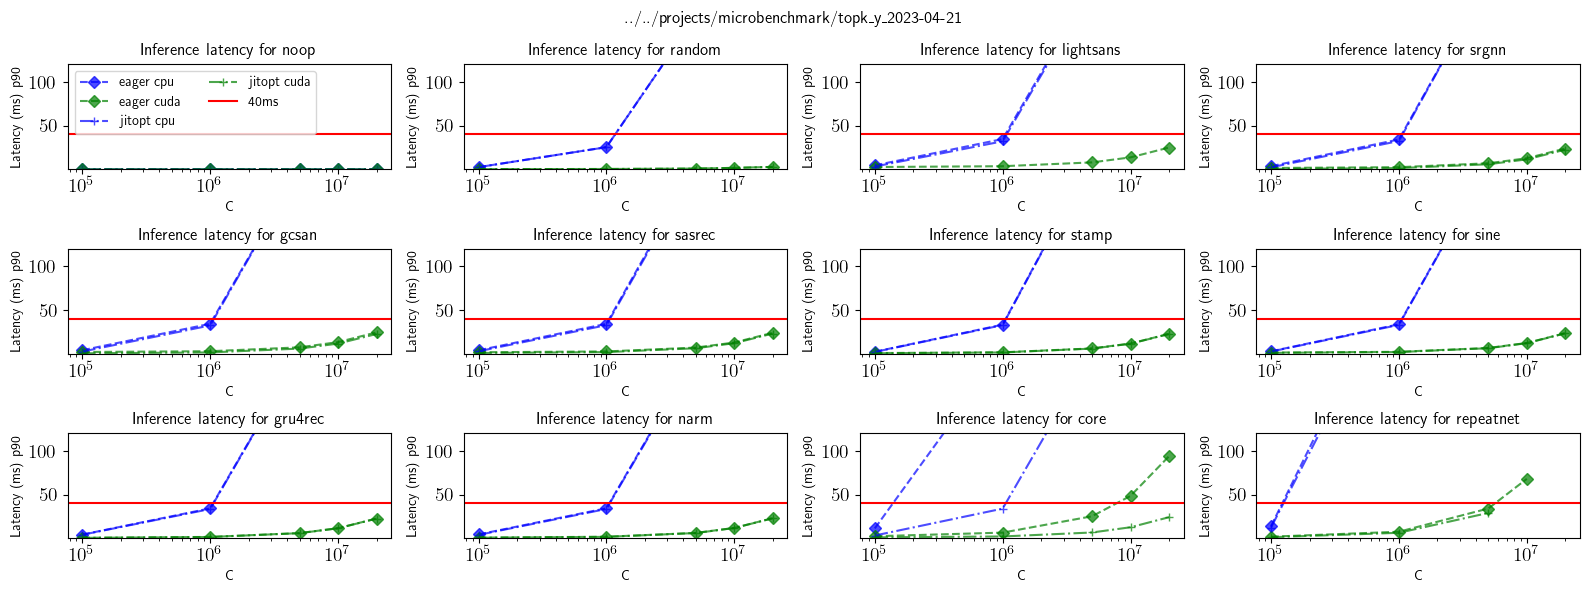

In [69]:
createplot('../../projects/microbenchmark/topk_y_2023-04-21')

In [15]:
model_name='random'
runtime = 'eager'
device = 'cuda'
datasource = 'bolcom'
directory='../../projects/microbenchmark/topk_y_2023-04-21/'
results = get_results(model_name, runtime, device, datasource, directory)


In [16]:
twenty_10m = results[10000000]
twenty_10m = twenty_10m.dropna()
twenty_10m

,LatencyInMs,DateTime,CPUUtilization,UsedMem,GPUUtilization,GPUMemUsed
0,4.201100,2023-04-21 19:56:47.723934,12.8,2631.0,2.0,39.0
1037,1.723963,2023-04-21 19:56:52.725566,12.7,2642.0,29.0,39.0
2049,1.996920,2023-04-21 19:56:57.727740,12.6,2642.0,35.0,39.0
3099,1.890693,2023-04-21 19:57:02.859521,12.6,2643.0,40.0,39.0
4149,1.861223,2023-04-21 19:57:07.980416,14.4,2641.0,40.0,39.0
5219,1.710681,2023-04-21 19:57:12.981966,12.6,2641.0,25.0,39.0
6242,1.715026,2023-04-21 19:57:17.982106,12.8,2642.0,40.0,39.0
7246,1.747170,2023-04-21 19:57:22.983914,12.6,2643.0,40.0,39.0
8249,1.879281,2023-04-21 19:57:28.138497,12.6,2644.0,40.0,39.0
9259,1.925281,2023-04-21 19:57:33.146882,12.6,2644.0,43.0,39.0


In [46]:
results[20000000].dropna()

,LatencyInMs,DateTime,CPUUtilization,UsedMem,GPUUtilization,GPUMemUsed
0,0.121520,2023-04-19 11:44:01.313068,13.7,3482.0,3.0,0.0
999,0.099564,2023-04-19 11:44:06.324018,14.7,3505.0,0.0,0.0
2049,0.112520,2023-04-19 11:44:11.544249,14.8,3505.0,0.0,0.0
3099,0.111005,2023-04-19 11:44:16.725262,14.7,3505.0,0.0,0.0
4079,0.103591,2023-04-19 11:44:21.834648,14.7,3506.0,0.0,0.0
5129,0.099598,2023-04-19 11:44:27.006766,14.7,3506.0,0.0,0.0
6129,0.099679,2023-04-19 11:44:32.118808,14.7,3506.0,0.0,0.0
7179,0.101849,2023-04-19 11:44:37.344044,14.9,3507.0,0.0,0.0
8179,0.102077,2023-04-19 11:44:42.445087,16.6,3508.0,0.0,0.0
9179,0.101565,2023-04-19 11:44:47.586448,14.7,3508.0,0.0,0.0


In [44]:
results[10000000].dropna()

,LatencyInMs,DateTime,CPUUtilization,UsedMem,GPUUtilization,GPUMemUsed
0,44.080750,2023-04-19 11:24:46.394330,14.0,3407.0,1.0,0.0
205,20.929845,2023-04-19 11:24:51.397595,13.1,3407.0,0.0,0.0
415,20.834598,2023-04-19 11:24:56.402437,13.1,3408.0,0.0,0.0
620,21.969499,2023-04-19 11:25:01.417558,13.0,3408.0,0.0,0.0
827,20.619970,2023-04-19 11:25:06.427800,13.0,3408.0,0.0,0.0
1036,22.737137,2023-04-19 11:25:11.450372,13.0,3408.0,0.0,0.0
1246,21.763474,2023-04-19 11:25:16.450033,13.1,3408.0,0.0,0.0
1449,21.754817,2023-04-19 11:25:21.528291,13.1,3408.0,0.0,0.0
1656,21.723839,2023-04-19 11:25:26.548935,13.2,3409.0,0.0,0.0
1864,21.377251,2023-04-19 11:25:31.555139,13.0,3409.0,0.0,0.0


In [37]:
results.keys()

dict_keys([20000000, 5000000, 1000000, 100000, 10000000])

In [42]:
model_name='random'
runtime = 'onnx'
device = 'cuda'
datasource = 'bolcom'
directory='../../projects/microbenchmark/topk_n_2023-04-19/results'
for root, dirs, files in os.walk(str(directory)):
        for file in files:
            if file.startswith(f'{model_name}_{runtime}_{device}_{datasource}'):
                C = int([part[1:] for part in file.split('_') if part.startswith('c')][-1])
                local_path = os.path.join(root, file)
                filename = f'{model_name}_{runtime}_{device}_{datasource}_c{C}_t50_results.pickle'
                f = os.path.join(directory, filename)
                if os.path.isfile(f):
                    r = read_results(f)
                    break
r

{'modelname': 'RANDOM',
 'C': 20000000,
 't': 50,
 'param_source': 'bolcom',
 'config': {'model': {'name': 'RANDOM'}, 'optimizer': {'lr': 0.02}, 'trainer': {'accelerator': 'auto'}, 'dataset': {'n_items': 20000000, 'max_seq_length': 50}},
 'model_architecture': 'RANDOMModel()',
 'runtime': 'onnx_cuda',
 'latency_df':       LatencyInMs                   DateTime  CPUUtilization  UsedMem  \
 0       87.916656 2023-04-19 11:50:30.607434            13.7   3608.0   
 1       43.754155 2023-04-19 11:50:30.651520             NaN      NaN   
 2       45.346993 2023-04-19 11:50:30.697235             NaN      NaN   
 3       43.155077 2023-04-19 11:50:30.740756             NaN      NaN   
 4       44.670984 2023-04-19 11:50:30.785797             NaN      NaN   
 ...           ...                        ...             ...      ...   
 1197    45.203350 2023-04-19 11:51:30.099113             NaN      NaN   
 1198    46.668704 2023-04-19 11:51:30.146158             NaN      NaN   
 1199    46.58251